In [2]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
import pandas as pd
from pyspark.sql import *
spark = SparkSession.builder.appName('Data_model').getOrCreate()
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import StructType, StructField, IntegerType

引入数据集

In [3]:
normalizer_df = spark.read.csv('/home/ubuntu/BDAS_yang124/Datasets/normalizer_df_pandas.csv',inferSchema=True,header=True)
normalizer_df.show(5)
normalizer_df.printSchema()

+---+-------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|_c0|Private|             Apps|           Accept|           Enroll|       F_Undergrad|       P_Undergrad|         Outstate|       Room_Board|         S_F_Ratio|           Expend|        Grad_Rate|
+---+-------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+
|  0|    Yes|7.415175109613295|7.117205503164344|6.582025138892826|7.9676267393338165|6.2878585601617845|8.914760527397261|8.101980731853192|2.9496883350525844|8.859647499714997|4.110873864173311|
|  1|    Yes|7.690286020676768|7.562681246721884|6.240275845170769| 7.895063498091573| 7.113142108707088|9.415808631610384|8.771990436532242| 2.580216829592325|9.261793653565098| 4.04305126783455|
|  2|    Yes|7.

In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
inputCols=['Apps',
 'Accept',
 'Enroll',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'S_F_Ratio',
 'Expend',
 'Grad_Rate']
assembler = VectorAssembler(
  inputCols=inputCols,
outputCol="features")
output = assembler.transform(normalizer_df)
indexer = StringIndexer(inputCol="Private", outputCol="PrivateIndex")
final_data_all = indexer.fit(output).transform(output)
final_data_all.show(5)


final_data = final_data_all.selectExpr("features","`PrivateIndex` as label")

final_data.show(5)


+---+-------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+--------------------+------------+
|_c0|Private|             Apps|           Accept|           Enroll|       F_Undergrad|       P_Undergrad|         Outstate|       Room_Board|         S_F_Ratio|           Expend|        Grad_Rate|            features|PrivateIndex|
+---+-------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-----------------+--------------------+------------+
|  0|    Yes|7.415175109613295|7.117205503164344|6.582025138892826|7.9676267393338165|6.2878585601617845|8.914760527397261|8.101980731853192|2.9496883350525844|8.859647499714997|4.110873864173311|[7.41517510961329...|         0.0|
|  1|    Yes|7.690286020676768|7.562681246721884|6.240275845170769| 7.895063

In [5]:
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

分割数据用于选择最佳模型，获取最佳参数

In [6]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

需要使用测模型构建，并且不适用参数并获取其评价分数

In [7]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
dtc = DecisionTreeClassifier()
nb = NaiveBayes()
lr_original_model=lr.fit(train_data)
rfc_original_model=rfc.fit(train_data)
dtc_original_model=dtc.fit(train_data)
nb_original_model=nb.fit(train_data)
lr_original_predictions=lr_original_model.transform(test_data)
rfc_original_predictions=rfc_original_model.transform(test_data)
dtc_original_predictions=dtc_original_model.transform(test_data)
nb_original_predictions=nb_original_model.transform(test_data)

from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_binary_eval = BinaryClassificationEvaluator()

print("DTC")
print(my_binary_eval.evaluate(dtc_original_predictions))
print("RFC")
print(my_binary_eval.evaluate(rfc_original_predictions))
print("LR")
print(my_binary_eval.evaluate(lr_original_predictions))
print("NB")
print(my_binary_eval.evaluate(nb_original_predictions))

DTC
0.8479603293413173
RFC
0.9739895209580839
LR
0.9746444610778443
NB
0.16064745508982034


In [8]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_evaluator = MulticlassClassificationEvaluator( predictionCol="prediction", metricName="accuracy")
dtc_acc = acc_evaluator.evaluate(dtc_original_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_original_predictions)
lr_acc = acc_evaluator.evaluate(lr_original_predictions)
nb_acc = acc_evaluator.evaluate(nb_original_predictions)

print('-'*40)
print('Decision tree has an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*40)
print('Random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('-'*40)
print(' LR has an accuracy of: {0:2.2f}%'.format(lr_acc*100))
print('-'*40)
print(' NB has an accuracy of: {0:2.2f}%'.format(nb_acc*100))

----------------------------------------
Decision tree has an accuracy of: 88.74%
----------------------------------------
Random forest ensemble has an accuracy of: 90.04%
----------------------------------------
 LR has an accuracy of: 93.07%
----------------------------------------
 NB has an accuracy of: 76.19%


参数选择，模型构建

In [9]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[lr])

paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)  

lr_best_model = crossval.fit(train_data)
params = lr_best_model.getEstimatorParamMaps()
avgMetrics = lr_best_model.avgMetrics
all_params = list(zip(params, avgMetrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]

print(best_param)


({Param(parent='LogisticRegression_41f9a6e688f46468615c', name='regParam', doc='regularization parameter (>= 0).'): 0.1}, 0.9577013368256411)


In [10]:
dtc = DecisionTreeClassifier()
pipeline = Pipeline(stages=[dtc])
paramGrid = ParamGridBuilder().addGrid(dtc.maxDepth,[5, 10]).addGrid(dtc.minInfoGain,[0,0.1,0.5,0.8, 1]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)  

dtc_best_Model = crossval.fit(train_data)


params = dtc_best_Model.getEstimatorParamMaps()
avgMetrics = dtc_best_Model.avgMetrics
all_params = list(zip(params, avgMetrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]

print(best_param)



({Param(parent='DecisionTreeClassifier_4171bf389c154c05ed96', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0, Param(parent='DecisionTreeClassifier_4171bf389c154c05ed96', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}, 0.8847541774268193)


In [11]:
rfc = RandomForestClassifier(numTrees=10)
pipeline = Pipeline(stages=[rfc])
paramGrid = ParamGridBuilder().addGrid(dtc.maxDepth,[5, 10]).addGrid(dtc.minInfoGain,[0,0.1,0.5,0.8, 1]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)  

rfc_best_Model = crossval.fit(train_data)


params = rfc_best_Model.getEstimatorParamMaps()
avgMetrics = rfc_best_Model.avgMetrics
all_params = list(zip(params, avgMetrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]

print(best_param)



({Param(parent='DecisionTreeClassifier_4171bf389c154c05ed96', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0, Param(parent='DecisionTreeClassifier_4171bf389c154c05ed96', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}, 0.9634871270618222)


In [12]:
nb = NaiveBayes()
pipeline = Pipeline(stages=[nb])
paramGrid = ParamGridBuilder().addGrid(nb.smoothing,[1,3,5,8, 10,15]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)  

nb_best_Model = crossval.fit(train_data)


params = nb_best_Model.getEstimatorParamMaps()
avgMetrics = nb_best_Model.avgMetrics
all_params = list(zip(params, avgMetrics))
best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]

print(best_param)


({Param(parent='NaiveBayes_4dbba36675206a53f9a1', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 1}, 0.15387579080958566)


参数选择后的模型进行评分

In [13]:
lr_best_predictions=lr_best_model.transform(test_data)
rfc_best_predictions=rfc_best_Model.transform(test_data)
dtc_best_predictions=dtc_best_Model.transform(test_data)
nb_best_predictions=nb_best_Model.transform(test_data)

my_binary_eval = BinaryClassificationEvaluator()

print("DTC_best")
print(my_binary_eval.evaluate(dtc_best_predictions))


print("RFC_best")
print(my_binary_eval.evaluate(rfc_best_predictions))

print("LR_best")
print(my_binary_eval.evaluate(lr_best_predictions))

print("NB_best")
print(my_binary_eval.evaluate(nb_best_predictions))

dtc_acc = acc_evaluator.evaluate(dtc_best_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_best_predictions)
lr_acc = acc_evaluator.evaluate(lr_best_predictions)
nb_acc = acc_evaluator.evaluate(nb_best_predictions)

print('-'*40)
print('A single decision tree has an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*40)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('-'*40)
print('An ensemble using LR has an accuracy of: {0:2.2f}%'.format(lr_acc*100))
print('-'*40)
print('An ensemble using NB has an accuracy of: {0:2.2f}%'.format(nb_acc*100))

DTC_best
0.8479603293413173
RFC_best
0.9716972305389222
LR_best
0.9605164670658684
NB_best
0.16064745508982034
----------------------------------------
A single decision tree has an accuracy of: 88.74%
----------------------------------------
A random forest ensemble has an accuracy of: 90.48%
----------------------------------------
An ensemble using LR has an accuracy of: 88.31%
----------------------------------------
An ensemble using NB has an accuracy of: 76.19%


In [31]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
def evaluate(predictionAndLabels):
    log = {}

    # Show Validation Score (AUROC)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    log['AUROC'] = "%f" % evaluator.evaluate(predictionAndLabels)    
    print("Area under ROC = {}".format(log['AUROC']))

    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['AUPR'] = "%f" % evaluator.evaluate(predictionAndLabels)
    print("Area under PR = {}".format(log['AUPR']))

    # Metrics
    predictionRDD = predictionAndLabels.select(['label', 'prediction']) .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    log['precision'] = "%s" % metrics.precision()
    log['recall'] = "%s" % metrics.recall()
    log['F1 Measure'] = "%s" % metrics.fMeasure()
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s" % (log['precision'], log['recall'], log['F1 Measure']))

    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        log[label] = {}
        log[label]['precision'] = "%s" % metrics.precision(label)
        log[label]['recall'] = "%s" % metrics.recall(label)
        log[label]['F1 Measure'] = "%s" % metrics.fMeasure(label, 
                                                           beta=1.0)
        print("[Class %s]\tprecision = %s | recall = %s | F1 Measure = %s" % (label, log[label]['precision'], log[label]['recall'], log[label]['F1 Measure']))

    return log

def drawcrue(model_name,roc,recall,precision,AUROC,AUPR):
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(recall, precision, 'k')
    plt.title(model_name + ' PR curve')
    plt.plot([(0, 0), (1, 1)], 'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 01.01])
    plt.text(0.5,0.1,'Area under PR = '+ AUPR,bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
    plt.ylabel('Precision')
    plt.xlabel('Recall')

    plt.subplot(1,2,2)
    
    x_val = [x[0] for x in roc]
    y_val = [x[1] for x in roc]
    plt.title(model_name + ' ROC curve')
    plt.xlabel('False posibality rate')
    plt.ylabel('True posibality rate')
    plt.plot(x_val, y_val)
    plt.text(0.5,0.1,'Area under ROC = '+ AUROC,bbox=dict(boxstyle="round",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
    plt.plot([(0,0),(1,1)],'r--')
    plt.show()

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)
    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points
    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)  



LR model metrics
Area under ROC = 0.960516
Area under PR = 0.897753
[[162.   5.]
 [ 22.  42.]]
[Overall]	precision = 0.8831168831168831 | recall = 0.8831168831168831 | F1 Measure = 0.8831168831168831
[Class 0.0]	precision = 0.8804347826086957 | recall = 0.9700598802395209 | F1 Measure = 0.923076923076923
[Class 1.0]	precision = 0.8936170212765957 | recall = 0.65625 | F1 Measure = 0.7567567567567568


/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:237: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")
/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:249: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")
/home/ubuntu/spark-2.1.1-bin-hadoop2.7/python/pyspark/mllib/evaluation.py:262: UserWarning: Deprecated in 2.0.0. Use accuracy.
  warnings.warn("Deprecated in 2.0.0. Use accuracy.")


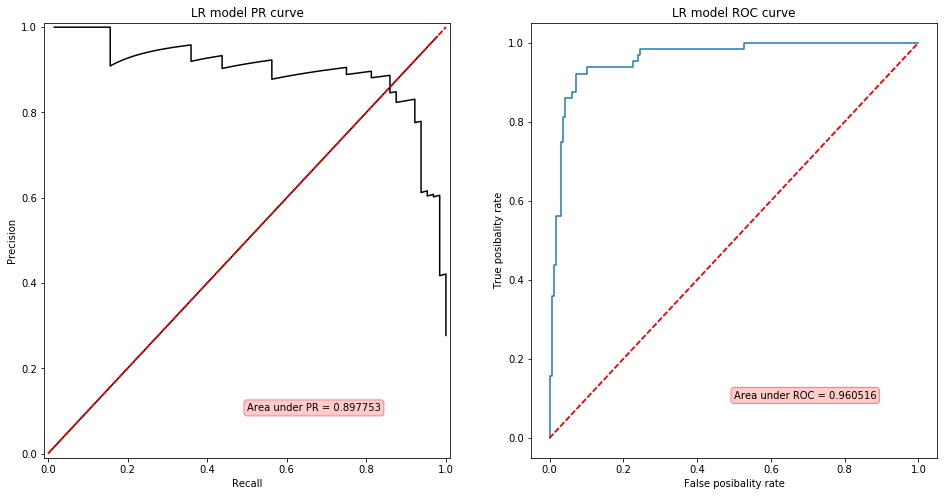

DTC model metrics
Area under ROC = 0.847960
Area under PR = 0.812622
[[151.  16.]
 [ 10.  54.]]
[Overall]	precision = 0.8874458874458875 | recall = 0.8874458874458875 | F1 Measure = 0.8874458874458875
[Class 0.0]	precision = 0.937888198757764 | recall = 0.9041916167664671 | F1 Measure = 0.9207317073170732
[Class 1.0]	precision = 0.7714285714285715 | recall = 0.84375 | F1 Measure = 0.8059701492537314


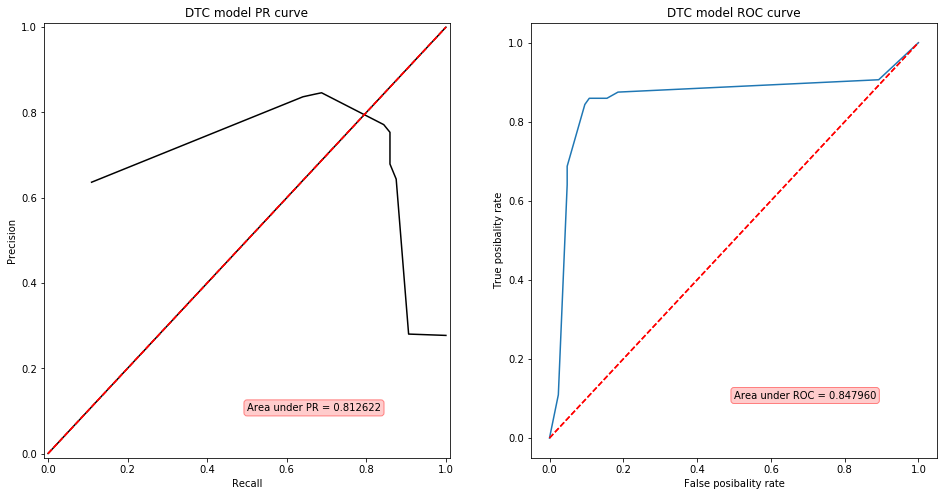

RF model metrics
Area under ROC = 0.971697
Area under PR = 0.908062
[[161.   6.]
 [ 16.  48.]]
[Overall]	precision = 0.9047619047619048 | recall = 0.9047619047619048 | F1 Measure = 0.9047619047619048
[Class 0.0]	precision = 0.9096045197740112 | recall = 0.9640718562874252 | F1 Measure = 0.9360465116279071
[Class 1.0]	precision = 0.8888888888888888 | recall = 0.75 | F1 Measure = 0.8135593220338982


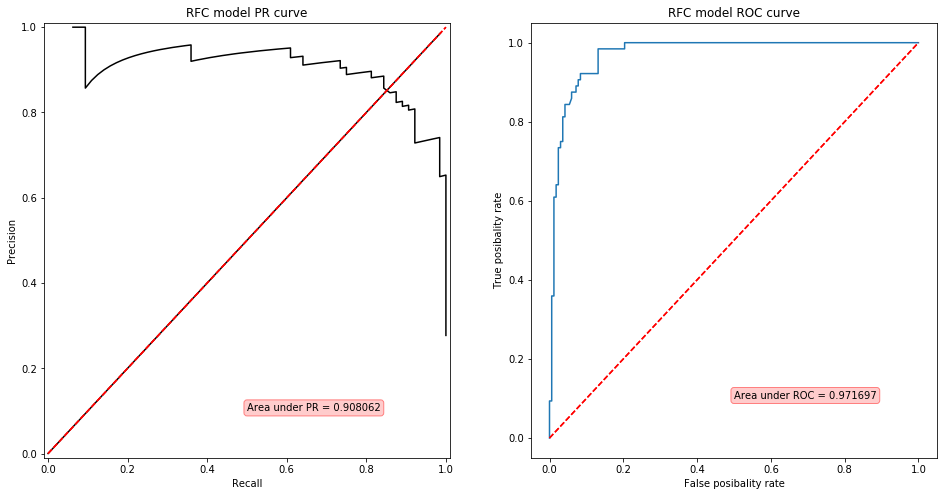

NB model metrics
Area under ROC = 0.160647
Area under PR = 0.167279
[[166.   1.]
 [ 54.  10.]]
[Overall]	precision = 0.7619047619047619 | recall = 0.7619047619047619 | F1 Measure = 0.7619047619047619
[Class 0.0]	precision = 0.7545454545454545 | recall = 0.9940119760479041 | F1 Measure = 0.8578811369509044
[Class 1.0]	precision = 0.9090909090909091 | recall = 0.15625 | F1 Measure = 0.2666666666666666


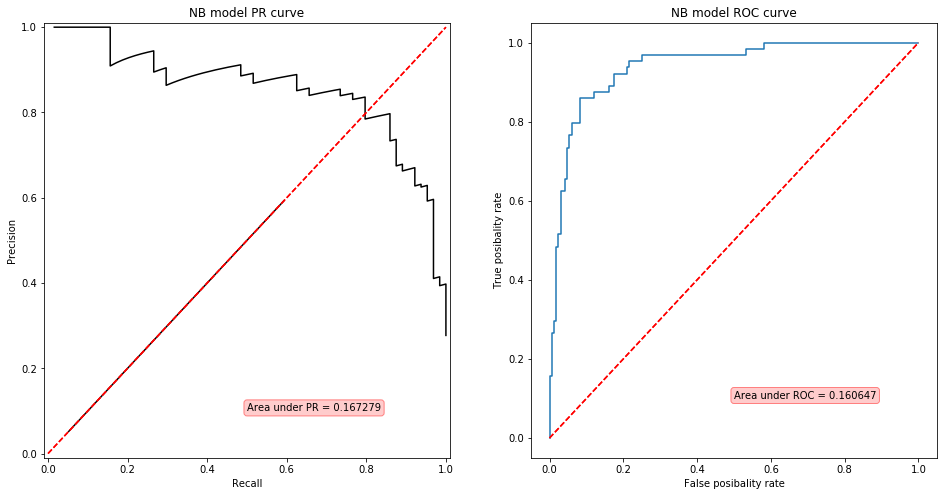

In [32]:
print("LR model metrics")
lr_log = evaluate(lr_best_predictions)

lr_preds = lr_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
lr_roc = CurveMetrics(lr_preds).get_curve('roc')
lr_metrics = CurveMetrics(lr_preds)
lr_f1_score = lr_metrics.get_curve('fMeasureByThreshold')
lr_precision = lr_metrics.get_curve('precisionByThreshold')
lr_recall = lr_metrics.get_curve('recallByThreshold')
lr_under_roc = lr_log['AUROC']
lr_under_pr = lr_log['AUPR']
drawcrue("LR model",lr_roc,lr_recall,lr_precision,lr_under_roc,lr_under_pr)

print("DTC model metrics")
dtc_log = evaluate(dtc_best_predictions)

dtc_preds = dtc_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
dtc_roc = CurveMetrics(dtc_preds).get_curve('roc')
dtc_metrics = CurveMetrics(dtc_preds)
dtc_f1_score = dtc_metrics.get_curve('fMeasureByThreshold')
dtc_precision = dtc_metrics.get_curve('precisionByThreshold')
dtc_recall = dtc_metrics.get_curve('recallByThreshold')

dtc_under_roc = dtc_log['AUROC']
dtc_under_pr = dtc_log['AUPR']
drawcrue("DTC model",dtc_roc,dtc_recall,dtc_precision,dtc_under_roc,dtc_under_pr)

print("RF model metrics")
rfc_log = evaluate(rfc_best_predictions)

rfc_preds = rfc_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
rfc_roc = CurveMetrics(rfc_preds).get_curve('roc')
rfc_metrics = CurveMetrics(rfc_preds)
rfc_f1_score = rfc_metrics.get_curve('fMeasureByThreshold')
rfc_precision = rfc_metrics.get_curve('precisionByThreshold')
rfc_recall = rfc_metrics.get_curve('recallByThreshold')

rfc_under_roc = rfc_log['AUROC']
rfc_under_pr = rfc_log['AUPR']
drawcrue("RFC model",rfc_roc,rfc_recall,rfc_precision,rfc_under_roc,rfc_under_pr)
print("NB model metrics")
nb_log = evaluate(nb_best_predictions)

nb_preds = nb_best_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
nb_roc = CurveMetrics(nb_preds).get_curve('roc')
nb_metrics = CurveMetrics(nb_preds)
nb_f1_score = nb_metrics.get_curve('fMeasureByThreshold')
nb_precision = nb_metrics.get_curve('precisionByThreshold')
nb_recall = nb_metrics.get_curve('recallByThreshold')

nb_under_roc = nb_log['AUROC']
nb_under_pr = nb_log['AUPR']
drawcrue("NB model",nb_roc,nb_recall,nb_precision,nb_under_roc,nb_under_pr)